In [60]:
import pandas as pd
pd.set_option('display.max_rows', 10000)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import sys
import glob
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from scipy.signal import savgol_filter
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import KFold
import torch.nn.functional as F
import torch.nn.init as init
import torch.nn.utils as torch_utils
import numpy as np
import pandas as pd
import re
from matplotlib import pyplot as plt
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

In [61]:
#%%


# %%
# INDOORS 1 SUN
file = pd.ExcelFile('Indoor MPP_ICN2_Nov. 2022_Tripple cat.-Variable Annealing temps.xlsx', engine='openpyxl')# the whole excel file 
sn = file.sheet_names # sheets that are the excel file 
data_frame = pd.read_excel(file,sn[0],  engine='openpyxl') # read the data from the first sheet 

temperature = data_frame.loc[(data_frame["Parameter"]     =="Annealing temperature")].to_numpy() #take the temperature from the row Annealing temperature of column Parameters and convert it to numpy
temperature = temperature[2,2:] # take everything from temperature starting from the third row and the third column
 
devices = data_frame.columns.to_numpy() # take the devices from the data and convert them to numpy
 
devices = np.reshape(devices, (devices.shape[0],1)) 
devices = devices[2:] #excluding the first two elements

time_series_df = pd.read_excel(file,sn[-1],  engine='openpyxl') # read the data from the last sheet

time_series_df = time_series_df.drop(index =[0]) # drop the first row (einheiten)
time = time_series_df.iloc[:,0] # take the time from the first column



# print(time)
time_series_1_sun = []
for i in range (temperature.shape[0]):
    time_series_1_sun.append(time_series_df.iloc[:,2+i*3]) ### for every device take the impp (optimal current output that the solar panel can generate when it is operating at its maximum power point)

time_series_1_sun = np.array(time_series_1_sun) # convert it to array [shape(24, 4001)]


# %% 
# 1.4 SUN

file = pd.ExcelFile('Indoor MPP_1.4 sun_ICN2_Feb. 2023_Tripple cat.-Variable Annealing temps.xlsx', engine='openpyxl')
sn = file.sheet_names
data_frame = pd.read_excel(file,sn[0],  engine='openpyxl')

# temperature
devices = data_frame.columns.to_numpy()
devices = np.reshape(devices, (devices.shape[0],1))
devices = devices[2:]
time_series_df = pd.read_excel(file,sn[-1],  engine='openpyxl')
time_series_df = time_series_df.drop(index =[0])
time = time_series_df.iloc[:,0]

# print(time)
time_series_1_4_sun = []
for i in range (temperature.shape[0]):
    time_series_1_4_sun.append(time_series_df.iloc[:,2+i*3])
time_series_1_4_sun = np.array(time_series_1_4_sun)#[shape(24, 1313)]



# %%
# %%
# OUTDOOR CONDITIONS
# file = pd.read_csv('outdoor_conditions.txt')
outdoor_conditions = pd.read_csv('outdoor_conditions_unnormalized.txt', sep='\t')

irradiance = outdoor_conditions['irradiance'] #[shape(4794,)]
rh = outdoor_conditions['rh'] #[shape(4794,)]
 
outdoor_temperature = outdoor_conditions['outdoor_temperature'] #[shape(4794,)]

outdoor_condition_time = outdoor_conditions['time'] #[shape(4794,)] 
irradiance = irradiance.fillna(irradiance.mean())
rh = rh.fillna(rh.mean())
outdoor_temperature = outdoor_temperature.fillna(outdoor_temperature.mean())
irradiance = irradiance.fillna(irradiance.mean())
rh = rh.fillna(rh.mean())
scaler = MinMaxScaler()
 
# Normalize irradiance column
irradiance_normalized = scaler.fit_transform(outdoor_conditions['irradiance'].values.reshape(-1, 1))

# Normalize rh column
rh_normalized = scaler.fit_transform(outdoor_conditions['rh'].values.reshape(-1, 1))

# Normalize outdoor_temperature column
outdoor_temperature_normalized = scaler.fit_transform(outdoor_conditions['outdoor_temperature'].values.reshape(-1, 1))

# Create a new DataFrame with normalized columns
outdoor_conditions_normalized = pd.DataFrame({
    'irradiance_normalized': irradiance_normalized.flatten(),
    'rh_normalized': rh_normalized.flatten(),
    'outdoor_temperature_normalized': outdoor_temperature_normalized.flatten(),
    'time': outdoor_conditions['time']
})

# Save the normalized DataFrame to a new file
outdoor_conditions_normalized.to_csv('outdoor_conditions_normalized.txt', sep='\t')
outdoor_conditions_normalized=pd.read_csv('outdoor_conditions_normalized.txt', sep='\t')
# %%
# OUTDOOR PANELS
# file = pd.read_csv('outdoor_conditions.txt')
outdoor_panels = pd.read_csv('outdoor_data_imputed.txt', sep ='\t')
# outdoor_panels.head()
outdoor_panels_power = [] 
for i in range(temperature.shape[0]):
    outdoor_panels_power.append(outdoor_panels[str(i)])
outdoor_panels_power = np.array(outdoor_panels_power) #[shape(24, 4794)]

#%%
# Padding


time_series_1_sun_shape = time_series_1_sun.shape
time_series_1_4_sun_shape = time_series_1_4_sun.shape
time_series_1_sun = np.pad(time_series_1_sun, ((0,0),(0,outdoor_panels_power.shape[1] - time_series_1_sun.shape[1])),mode='edge')    
time_series_1_4_sun = np.pad(time_series_1_4_sun, ((0,0),(0,outdoor_panels_power.shape[1] - time_series_1_4_sun.shape[1])),mode='edge' )    
time_series_1_sun = np.reshape(time_series_1_sun, ((time_series_1_sun.shape[0],time_series_1_sun.shape[1],1)))
time_series_1_4_sun = np.reshape(time_series_1_4_sun, ((time_series_1_4_sun.shape[0],time_series_1_4_sun.shape[1],1)))
outdoor_panels_power = np.reshape(outdoor_panels_power, ((outdoor_panels_power.shape[0],outdoor_panels_power.shape[1],1)))

In [62]:
outdoor_conditions_stacked= np.stack([outdoor_conditions] * 24, axis=0)
all_new_features = np.concatenate((time_series_1_sun, outdoor_conditions_stacked), axis=2)
print(all_new_features.shape)



(24, 4794, 6)


In [63]:
# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('CUDA is available. Using GPU for computations.')
else:
    device = torch.device('cpu')
    print('CUDA is not available. Using CPU for computations.')

CUDA is not available. Using CPU for computations.


Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0262
Function value obtained: 2.1377
Current minimum: 2.1377
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0231
Function value obtained: 2.3480
Current minimum: 2.1377
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0212
Function value obtained: 2.3474
Current minimum: 2.1377
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0202
Function value obtained: 2.7077
Current minimum: 2.1377
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.0195
Function value obtained: 2.3481
Current minimum: 2.1377
Iteration No: 6 started. Evaluating

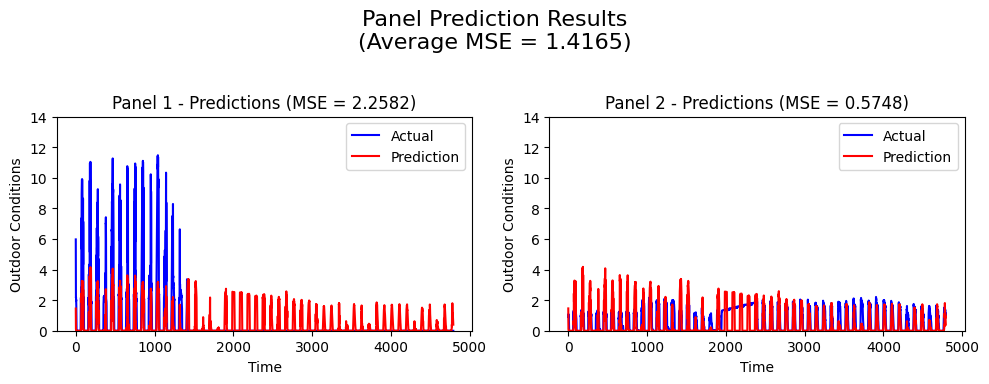

[1.44920370e+00 1.09526239e-01 1.06405081e-01 6.29288394e-02
 1.46576861e-02 4.48894461e-03 1.12970327e-04 2.05577727e-04
 2.04383343e-04 1.61657683e-04 1.20703939e-04 1.40703779e-04
 1.34679212e-04 1.51510380e-04 9.93446246e-05 1.77957232e-04
 6.62586880e-05 1.39762559e-04 1.27177761e-04 1.22431648e-04]
[1.45828335e+00 1.10476643e-01 1.07257174e-01 6.33323923e-02
 1.47689792e-02 4.51193513e-03 1.13404648e-04 2.07650505e-04
 2.05804322e-04 1.62457321e-04 1.22132007e-04 1.42558645e-04
 1.35130666e-04 1.53388235e-04 1.00592706e-04 1.78698372e-04
 6.76548479e-05 1.42247250e-04 1.28564297e-04 1.24488773e-04]


In [64]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from skopt import gp_minimize
from skopt.space import Categorical, Real, Integer
from sklearn.kernel_ridge import KernelRidge
import matplotlib.pyplot as plt

# Assuming you have already loaded and preprocessed your data into all_new_features and outdoor_panels_power_average

# Prepare training and test data
num_samples_train = 11
num_samples_test=2
all_new_features_train_1= all_new_features[:num_samples_train].reshape(num_samples_train, -1)
outdoor_panels_power_train_1 = outdoor_panels_power[:num_samples_train].reshape(num_samples_train, -1)

all_new_features_test = all_new_features[-num_samples_test:].reshape(num_samples_test, -1)
outdoor_panels_power_test = outdoor_panels_power[-num_samples_test:].reshape(num_samples_test, -1)

# Define the hyperparameter search space using skopt's Categorical, Real, and Integer spaces
param_space = {
    'kernel': Categorical(['linear', 'rbf', 'poly']),
    'alpha': Real(0.001, 20.0, prior='log-uniform'),  # Expanded alpha range from 0.001 to 10.0
    'gamma': Real(0.0001, 20.0, prior='log-uniform'),  # Expanded gamma range from 0.0001 to 10.0
    'degree': Integer(1, 5),  # Expanded degree range from 1 to 5
    'coef0': Real(-2.0, 2.0),  # Expanded coef0 range from -1.0 to 1.0
}


# Define the objective function to optimize (MSE in this case)
def objective_function(params):
    kernel = params[0]
    alpha = params[1]
    gamma = params[2]
    degree = params[3]
    coef0 = params[4]
    
    # Create the KRR model with the given hyperparameters
    krr_model = KernelRidge(kernel=kernel, alpha=alpha, gamma=gamma, degree=degree, coef0=coef0)
    
    # Fit the model on the training data
    krr_model.fit(all_new_features_train_1, outdoor_panels_power_train_1)
    
    # Make predictions on the test data
    y_pred = krr_model.predict(all_new_features_test)
    
    # Calculate the mean squared error
    mse = mean_squared_error(outdoor_panels_power_average_test, y_pred)
    
    # Negative sign as we want to minimize MSE, and skopt maximizes the objective function
    return mse

# Perform Bayesian optimization with gp_minimize using Gaussian Process Regression
result = gp_minimize(
    objective_function,
    dimensions=list(param_space.values()),
    n_calls=100,  # Number of function calls (adjust as needed)
    random_state=42,
    
    verbose=1
)

# Get the best hyperparameters from the optimization results
best_params = dict(zip(param_space.keys(), result.x))
print("Best Hyperparameters:", best_params)

# Create the KRR model with the best hyperparameters
best_krr_model = KernelRidge(**best_params)

# Fit the best model on the training data
best_krr_model.fit(all_new_features_train_1, outdoor_panels_power_train_1)

# Predict with the best model
y_pred_best = best_krr_model.predict(all_new_features_test)

# Plot the predictions for each sample in the test set
y_pred_best = y_pred_best.reshape(num_samples_test, -1)

# Plot the predictions for each sample in the test set
mse_errors = []

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
mse_errors = []  # Initialize the list to store MSE errors

# Iterate over each panel's predictions
for i, ax in enumerate(axs.flat):
    ax.plot(outdoor_panels_power_average_test[i], label='Actual', color='blue')
    ax.plot(y_pred_best[i], label='Prediction', color='red')
    ax.set_xlabel('Time')
    ax.set_ylabel('Outdoor Conditions')
    
    # Set the y-axis limits to the desired range
    ax.set_ylim(0, 14) 
    
    # Calculate the Mean Squared Error
    mse = mean_squared_error(outdoor_panels_power_test[i], y_pred_best[i])
    mse_errors.append(mse)
    
    # Add the MSE to the title of the plot
    ax.set_title('Panel {} - Predictions (MSE = {:.4f})'.format(i + 1, mse))
    ax.legend()

# Calculate the average MSE
average_mse = np.mean(mse_errors)

# Add a big title for the entire plot with the average MSE
plt.suptitle("Panel Prediction Results\n(Average MSE = {:.4f})".format(average_mse), fontsize=16)
plt.savefig('test_results.pdf')
# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print(y_pred_best[0, :20])
print(y_pred_best[1, :20])

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.0222
Function value obtained: 2.1377
Current minimum: 2.1377
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.0192
Function value obtained: 2.8927
Current minimum: 2.1377
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.0224
Function value obtained: 2.8711
Current minimum: 2.1377
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.0203
Function value obtained: 2.2193
Current minimum: 2.1377
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.0175
Function value obtained: 2.8945
Current minimum: 2.1377
Iteration No: 6 started. Evaluating

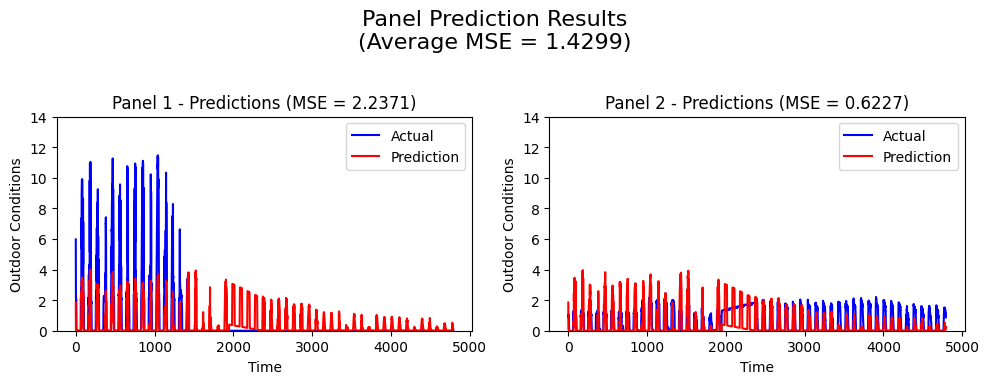

[ 1.85942996e+00  1.28889407e-01  1.25184652e-01  8.06301486e-02
  3.43690738e-02 -2.03360362e-03 -3.17360902e-03 -6.09192485e-04
 -3.71177608e-03  8.68459149e-05  6.40542178e-05 -4.69076323e-05
  1.28323246e-04  5.42952336e-05  8.00607921e-05  2.28448500e-05
  3.34661238e-04 -2.54152282e-04  1.11011381e-04  3.10135858e-04]
[ 1.84516788e+00  1.27940021e-01  1.24062555e-01  7.98858068e-02
  3.42265394e-02 -2.08638261e-03 -3.18288355e-03 -5.73780331e-04
 -3.75767379e-03  8.39989466e-05  6.05926482e-05 -5.07638827e-05
  1.26743456e-04  5.19172683e-05  7.64130718e-05  2.14967395e-05
  3.35427350e-04 -2.59406312e-04  1.11643235e-04  3.12115531e-04]


In [65]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from skopt import gp_minimize
from skopt.space import Categorical, Real, Integer
from sklearn.kernel_ridge import KernelRidge
import matplotlib.pyplot as plt

# Assuming you have already loaded and preprocessed your data into all_new_features and outdoor_panels_power_average

# Prepare training and test data
num_samples_train = 11
num_samples_test=2
all_new_features_train_1 = all_new_features[train_start_index:train_end_index]
outdoor_panels_power_train_1 = outdoor_panels_power[train_start_index:train_end_index]

# Reshape the data to match the expected input shape
all_new_features_train_1 = all_new_features_train_1.reshape(num_samples_train, -1)
outdoor_panels_power_train_1 = outdoor_panels_power_train_1.reshape(num_samples_train, -1)

all_new_features_test = all_new_features[-num_samples_test:].reshape(num_samples_test, -1)
outdoor_panels_power_test = outdoor_panels_power[-num_samples_test:].reshape(num_samples_test, -1)

# Define the hyperparameter search space using skopt's Categorical, Real, and Integer spaces
param_space = {
    'kernel': Categorical(['linear', 'rbf', 'poly']),
    'alpha': Real(0.001, 20.0, prior='log-uniform'),  # Expanded alpha range from 0.001 to 10.0
    'gamma': Real(0.0001, 20.0, prior='log-uniform'),  # Expanded gamma range from 0.0001 to 10.0
    'degree': Integer(1, 5),  # Expanded degree range from 1 to 5
    'coef0': Real(-2.0, 2.0),  # Expanded coef0 range from -1.0 to 1.0
}


# Define the objective function to optimize (MSE in this case)
def objective_function(params):
    kernel = params[0]
    alpha = params[1]
    gamma = params[2]
    degree = params[3]
    coef0 = params[4]
    
    # Create the KRR model with the given hyperparameters
    krr_model = KernelRidge(kernel=kernel, alpha=alpha, gamma=gamma, degree=degree, coef0=coef0)
    
    # Fit the model on the training data
    krr_model.fit(all_new_features_train_1, outdoor_panels_power_train_1)
    
    # Make predictions on the test data
    y_pred = krr_model.predict(all_new_features_test)
    
    # Calculate the mean squared error
    mse = mean_squared_error(outdoor_panels_power_average_test, y_pred)
    
    # Negative sign as we want to minimize MSE, and skopt maximizes the objective function
    return mse

# Perform Bayesian optimization with gp_minimize using Gaussian Process Regression
result = gp_minimize(
    objective_function,
    dimensions=list(param_space.values()),
    n_calls=100,  # Number of function calls (adjust as needed)
    random_state=42,
    
    verbose=1
)

# Get the best hyperparameters from the optimization results
best_params = dict(zip(param_space.keys(), result.x))
print("Best Hyperparameters:", best_params)

# Create the KRR model with the best hyperparameters
best_krr_model = KernelRidge(**best_params)

# Fit the best model on the training data
best_krr_model.fit(all_new_features_train_1, outdoor_panels_power_train_1)

# Predict with the best model
y_pred_best = best_krr_model.predict(all_new_features_test)

# Plot the predictions for each sample in the test set
y_pred_best = y_pred_best.reshape(num_samples_test, -1)

# Plot the predictions for each sample in the test set
mse_errors = []

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
mse_errors = []  # Initialize the list to store MSE errors

# Iterate over each panel's predictions
for i, ax in enumerate(axs.flat):
    ax.plot(outdoor_panels_power_average_test[i], label='Actual', color='blue')
    ax.plot(y_pred_best[i], label='Prediction', color='red')
    ax.set_xlabel('Time')
    ax.set_ylabel('Outdoor Conditions')
    
    # Set the y-axis limits to the desired range
    ax.set_ylim(0, 14) 
    
    # Calculate the Mean Squared Error
    mse = mean_squared_error(outdoor_panels_power_test[i], y_pred_best[i])
    mse_errors.append(mse)
    
    # Add the MSE to the title of the plot
    ax.set_title('Panel {} - Predictions (MSE = {:.4f})'.format(i + 1, mse))
    ax.legend()

# Calculate the average MSE
average_mse = np.mean(mse_errors)

# Add a big title for the entire plot with the average MSE
plt.suptitle("Panel Prediction Results\n(Average MSE = {:.4f})".format(average_mse), fontsize=16)
plt.savefig('test_results.pdf')
# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print(y_pred_best[0, :20])
print(y_pred_best[1, :20])